# <span style = 'color: red'>***A.*** **Preprocesamiento**.

En este *notebook* se desarrolla el **preprocesamiento** de los datos, con la finalidad de obtener unos datos adecuados de cara al proceso de modelación. Así, se abordará la limpieza de datos, la transformación de los mismos, aplicación de reducción de dimensionalidad, balanceo de los datos y la construcción de conjuntos de entrenamiento y de prueba.

In [125]:
#
# Importanción de librerías de interés
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from janitor import clean_names
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif


# <span style = 'color: red'>***1.***</span> Lectura de los datos

Los datos se obtiene de Kaggle y están disponibles [aquí](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data). Es importante anotar que los dueños de la información reportan en la documentación de la misma (visible en el enlace anterior) que las características adjuntas son todas de corte numérico y ya pasaron por un preprocesamiento previo. Además, dada la sensibilidad, los dueños de la base establecen que no pueden revelar el significado de los diferentes campos, por lo que la mayoría de los datos están *anonimizados* de la forma $V_i, i = 1, \dots, 28$. Se tienen otras dos cantidad que no fueron transformadas: el tiempo (`time`, que representa la cantidad de segundos transcurridos entre la primera transacción del marco de datos y la del registro propiamente) y el monto de la transacción (`amount`). Sin embargo, como parte de un control de calidad, se realizará un preprocesamiento adicional.

Es clave anotar que la variable objetivo de esta base es `class` y que esta:
- es `1` cuando la transacción corresponde a un fraude.
- es `0` cuando la transacción *no* es fraudulenta.

In [2]:
#
# Lectura de datos
direc = '../Datos/creditcard.csv.zip'
datos = pd.read_csv(direc, compression='zip')

# Limpieza de título
datos = datos.clean_names()

print(
    f'El conjunto de datos tiene {datos.shape[0]} filas y {datos.shape[1]} columnas.'
)

El conjunto de datos tiene 284807 filas y 31 columnas.


In [3]:
#
# Estructura de los datos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

In [4]:
datos.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


De acuerdo con esta revisión inicial, y atendiendo la documentación de la base, la lectura de los datos es correcto y todas las características tienen la tipología de datos adecuada.

# <span style = 'color: red'>***2.***</span> Limpieza de los datos

## <span style = 'color: green'>**2.1.**</span> Duplicados y datos faltantes

Se comenzará revisando si existen filas duplicadas.

In [5]:
#
# Revisión de duplicados
duplicados = datos.duplicated().sum()
print(f'El conjunto de datos tiene {duplicados} filas duplicadas.')

El conjunto de datos tiene 1081 filas duplicadas.


Como se observa, para todas las características se tienen columnas de color gris continuo. Esto indica que la base carece de datos faltantes. De todos modos, se busca de manera manual si existen datos nulos, corroborando que no es el caso. Esto hace que no sea necesario imputar información y, por otra parte, el marco de datos será adecuado para cualquier tipo de modelo (entendiendo que algunos no aceptan valores faltantes).

In [6]:
#
# Eliminación de duplicados
if duplicados > 0:
    datos = datos.drop_duplicates()
    print(f'Se eliminaron {duplicados} filas duplicadas.')
    print(f'El conjunto de datos ahora tiene {datos.shape[0]} filas y {datos.shape[1]} columnas.')
else:
    print('No se eliminaron filas duplicadas.')

Se eliminaron 1081 filas duplicadas.
El conjunto de datos ahora tiene 283726 filas y 31 columnas.


Ahora, se revisará la nulidad de información en esta base de datos:

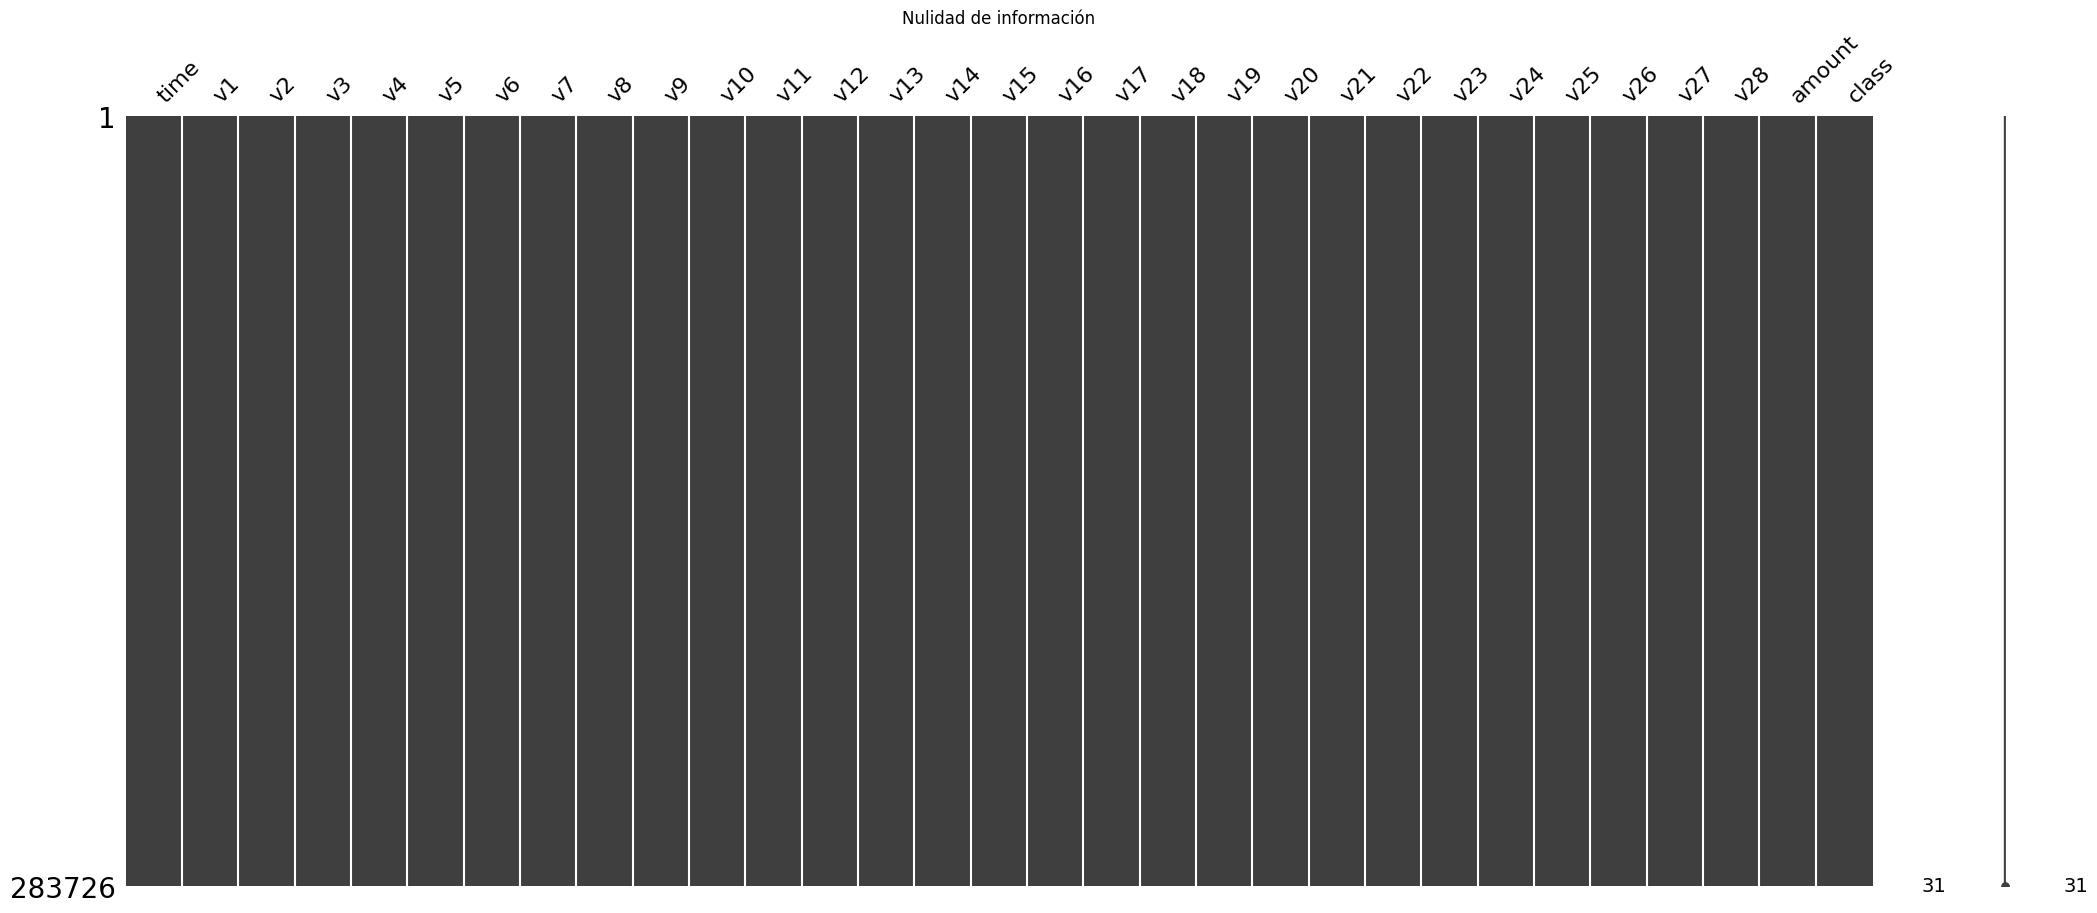

El conjunto de datos tiene 0 valores nulos.


In [7]:
#
# Nulidad de información
msno.matrix(datos)
plt.title('Nulidad de información')
plt.show()

print(
    f'El conjunto de datos tiene {datos.isnull().sum().sum()} valores nulos.'
)

## <span style = 'color: green'>**2.2.**</span> Observaciones atípicas

A continuación, se identificarán las observaciones atípicas, entendiéndolas como aquellas que están 1.5 veces el rango intercuartílico por encima del tercer cuartil ($Q3$) o por debajo del primer cuartil ($Q1$). Estos son los valores que típicamente quedan representados como puntos en gráficos de cajas y bigotes. Se realizará el análisis detallando si existe un sesgo especial hacia la clase que marca el fraude, lo que indica una relevancia especial de la característica.

In [8]:
outlier_df = pd.DataFrame(index=datos.index)

for col in datos.select_dtypes(include=['number']).columns:
    q1 = datos[col].quantile(0.25)
    q3 = datos[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_df[col + '_outlier'] = ((datos[col] < lower) | (datos[col] > upper))


In [9]:
for col in datos.select_dtypes(include=['number']).columns:
    etiqueta_outlier = outlier_df[col + '_outlier']
    tabla = pd.crosstab(etiqueta_outlier, datos['class'], normalize='columns')  # proporción sobre cada clase
    print(f"\nDistribución de datos atípicos en {col}:")
    print(tabla)



Distribución de datos atípicos en time:
class           0    1
time_outlier          
False         1.0  1.0

Distribución de datos atípicos en v1:
class              0         1
v1_outlier                    
False       0.976028  0.665962
True        0.023972  0.334038

Distribución de datos atípicos en v2:
class             0         1
v2_outlier                   
False       0.95354  0.513742
True        0.04646  0.486258

Distribución de datos atípicos en v3:
class              0        1
v3_outlier                   
False       0.989363  0.38055
True        0.010637  0.61945

Distribución de datos atípicos en v4:
class              0         1
v4_outlier                    
False       0.961893  0.365751
True        0.038107  0.634249

Distribución de datos atípicos en v5:
class              0         1
v5_outlier                    
False       0.957529  0.596195
True        0.042471  0.403805

Distribución de datos atípicos en v6:
class              0         1
v6_outlier   

En general, los datos atípicos son importantes para poder identificar que una transacción tiene una mayor probabilidad de fraude. Esto se puede constatar con el hecho de que para las diferentes variables del modelo, los datos atípicos suelen distribuirse de manera más pareja o incluso modera a fuertemente sesgada para aquellas instancias en las que se marca un ***fraude***, caso contrario de las observaciones no fraudulentas, que suelen tener una menor asociación con los datos atípicos. 

Un ejemplo muy visible de esto ocurre con la característica `v14`: para esta, en las instancias fraudulentas, el 86.8 \% de ellas toman un valor atípico para esta variable, mientras que en las no fraudulentas solo el 4.8 \% de las observaciones serán atípicas. Es importante anotar que, si bien este comportamiento no se repite para todas las características, sí se observa algo semejante en la mayoría de ellas; en cambio, para las instancias no atípicas hay una baja tasa de datos atípicos.

Este análisis permite concluir que **no es adecuado eliminar, limpias o imputar las observaciones atípicas**.

## <span style = 'color: green'>**2.3.**</span> Análisis de multicolinealidad

Ahora, se revisará si existen características fuertemente asociadas entre sí mediante un análisis de multicolinealidad:

<Figure size 1000x800 with 0 Axes>

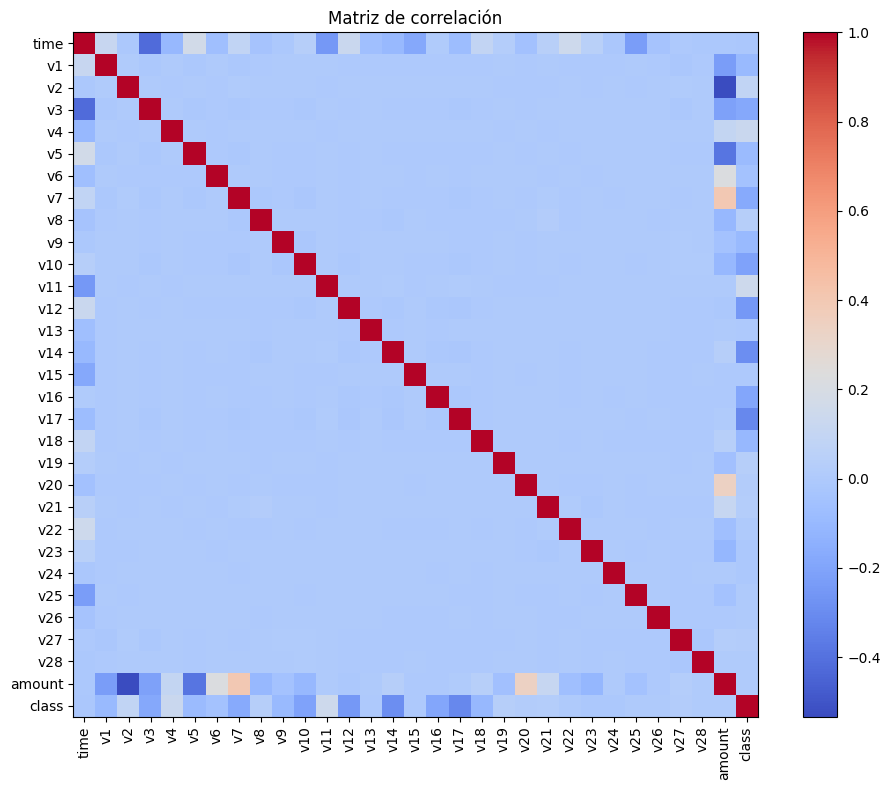

In [10]:
#
# Matriz de correlación

plt.figure(figsize=(10, 8))
corr_matrix = datos.select_dtypes(include='number').corr()

plt.figure(figsize=(10,8))
plt.title("Matriz de correlación")
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.tight_layout()
plt.show()


En general, las variables presentan una correlación lineal débil o moderada-débil entre sí. Solo vale la pena destacar la correlación entre `amount` y `v7`, que es de un $0.4$ aproximadamente, y la de `v2` y `amount`, que es de un $-0.6$ aproximadamente. Con esto en mente, no merece la pena eliminar ninguna variable del marco de datos entiendo como que puede quedar representada por otra muy altamente correlacionada.

Frente a la correlación con la variable objetivo, todas tienen correlaciones muy cercanas a cero. Las que más destacan son `v10`, `v14` y `v17`, con correlaciones de un $-0.1$ aproximadamente.

El anterior análisis se puede complementar con el $VIF$: *factor de inflación de varianza*. Valores de $VIF > 5$ pueden ser preocupantes.

In [11]:
#
# VIF
X_vif = datos.select_dtypes(include='number').drop(columns=['target'], errors='ignore')  # omite target si es numérica

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


   feature        VIF
0     time   2.353494
1       v1   1.641115
2       v2   3.935012
3       v3   1.321541
4       v4   1.175845
5       v5   2.768500
6       v6   1.534962
7       v7   2.597499
8       v8   1.100627
9       v9   1.038344
10     v10   1.206976
11     v11   1.081375
12     v12   1.156400
13     v13   1.003508
14     v14   1.218507
15     v15   1.014528
16     v16   1.082241
17     v17   1.227937
18     v18   1.034703
19     v19   1.041104
20     v20   2.239606
21     v21   1.102076
22     v22   1.083716
23     v23   1.154567
24     v24   1.000789
25     v25   1.013744
26     v26   1.000561
27     v27   1.010457
28     v28   1.001859
29  amount  11.659063
30   class   2.029128


Como se observa, todas las variables tienen un $VIF < 3$, lo que las hace adecuadas para la modelación excepto por la columna del monto de la transacción con un $VIF_{\texttt{amount}} = 11.6$. No obstante, basados en un **criterio experto de negocio** (en riesgo de crédito), esta variable suele tener una incidencia importante en el fraude, por lo que vale la pena conservarla.  

En efecto, existe un gran desbalanceo en el marco de datos, con solo el $0.17 \%$ asociados a la marca de ***fraude***.

## <span style = 'color: green'>**2.4.**</span> Pasos finales: separación de datos, dalanceo, estandarización y reducción de dimensionalidad

Ahora se va a proceder con los pasos finales que van a permitir configurar el marco de datos que se empleará para el entrenamiento del modelo, a saber:

- **Definición de conjuntos de entrenamiento y validación**
- **Balanceo de los datos**, ya que los autores hablan de que hay un desbalanceo exacerbado de la información, como se verá más adelante.
- **Estandarización de los datos**, que si bien en teoría ya están aplicados de antemano por parte de los dueños de los datos, se apelará de nuevo a este proceso como control de calidad. Se va a realizar un sobremuestreo usando `SMOTE`, que es una de las técnicas más populares para este tipo de actividades.
- **Reducción de dimensionalidad**, para tratar de simplificar el volumen de los datos, abarcando por lo menos un 97.5 \% de la varianza de los mismos.

Antes de definir el *pipeline*, se va a mostrar la distribución de la variable respuesta para que sea notorio el desbalanceo.

Veamos cómo quedó el balanceo de la información:

C:\Users\user\AppData\Local\Temp\ipykernel_15140\3881773891.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='viridis')


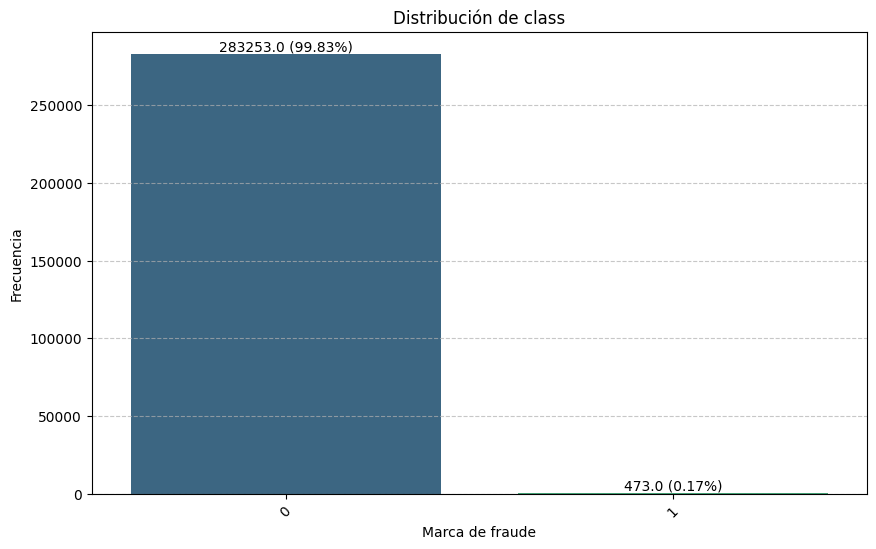

In [12]:
#
# Función que grafica la distribución
def plot_distribution(data, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column, palette='viridis')
    # Agregar proporción y cantidad absoluta encima de cada barra
    total = len(data)
    for p in plt.gca().patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width() / 2., height, f'{height} ({height / total:.2%})',
                 ha='center', va='bottom', fontsize=10, color='black')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f'Distribución de {column}')
    plt.xlabel('Marca de fraude')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

plot_distribution(datos, 'class')

En efecto, existe un gran desbalanceo en el marco de datos, con solo el $0.17 \%$ asociados a la marca de *fraude*. Ahora, se procese con la realización de los pasos descritos previamente. Nótese que el balanceo de información se aplicará solo sobre los datos del conjunto de entrenamiento.

In [55]:
#
# Consolidación de la información
# 
# # 1. Separa en entrenamiento y validación (stratify mantiene la proporción de clases)
X = datos.drop('class', axis=1)
y = datos['class']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=202508
)

# 2. Aplica SMOTE SOLO al set de entrenamiento
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 3. Escalado y PCA SOLO se ajustan en entrenamiento y luego se aplican en validación
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)

pca = PCA(n_components=0.95)
X_train_final = pca.fit_transform(X_train_res_scaled)
X_val_final = pca.transform(X_val_scaled)

# Tus conjuntos quedan así:
# - X_train_final, y_train_res → Para entrenamiento (balanceados, estandarizados, reducidos)
# - X_val_final, y_val         → Para validación (no balanceado, estandarizado y reducido igual que train)

print("Train:", X_train_final.shape, y_train_res.shape)
print("Validación:", X_val_final.shape, y_val.shape)


Train: (453204, 17) (453204,)
Validación: (56746, 17) (56746,)


C:\Users\user\AppData\Local\Temp\ipykernel_15140\3881773891.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='viridis')


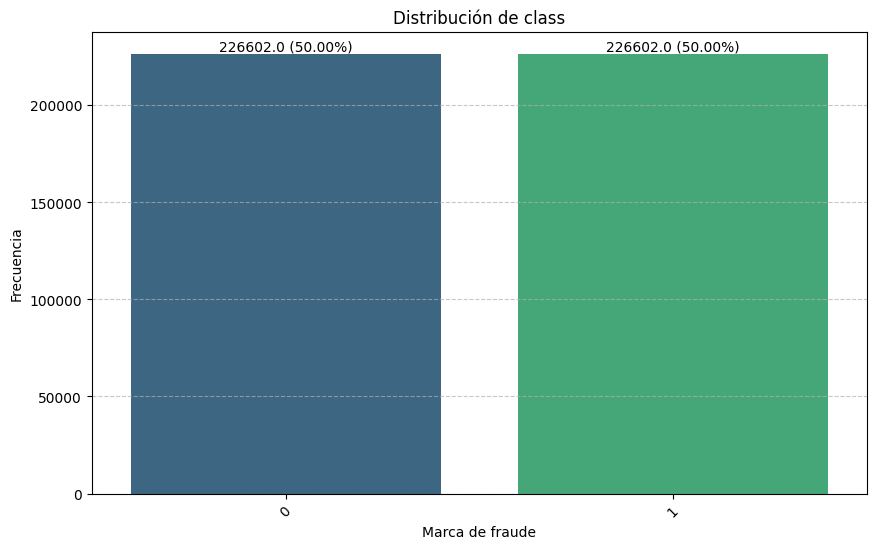

In [56]:
#
# Distribución de la variable objetivo a partir de y_res
plot_distribution(pd.DataFrame({'class': y_train_res}), 'class')

Como se puede observar, ambas instancias están perfectamente balanceadas ahora para el conjunto de entrenamiento.

In [60]:
#
# Unión de los datos

# Junta para entrenamiento
df_train = pd.DataFrame(X_train_final)
df_train['class'] = y_train_res.values  # y_train_res puede ser Series o ndarray

# Junta para validación
df_val = pd.DataFrame(X_val_final)
df_val['class'] = y_val.values


In [16]:
#
# Dimensionalidad

print(
    f'El conjunto de entrenamiento tiene {X_train_final.shape[0]} filas y {X_train_final.shape[1]} columnas.',
    f'El conjunto de validación tiene {X_val_final.shape[0]} filas y {X_val_final.shape[1]} columnas.',
    sep='\n\n'
)

El conjunto de entrenamiento tiene 453204 filas y 17 columnas.

El conjunto de validación tiene 56746 filas y 17 columnas.


Nótese que del proceso de reducción de dimensionalidad, se conservan un total de 17 características que, en conjunto, responden por más del $97.5 \%$ de la varianza de los datos.

## <span style = 'color: green'>**2.4.**</span> Guardado de los datos

Con esto, se procederá a guardar estos datos para que puedan ser consumidos en otros *notebooks*.

In [17]:
#
# # Define la ruta relativa desde donde está tu notebook
base_dir = os.path.dirname(os.getcwd())  # Subes un nivel desde la carpeta del notebook
procesados_dir = os.path.join(base_dir, "datos", "Procesados")
os.makedirs(procesados_dir, exist_ok=True)

# Guarda los archivos como .csv.zip
df_train.to_csv(os.path.join(procesados_dir, "train.csv.zip"), index=False, compression='zip')
df_val.to_csv(os.path.join(procesados_dir, "validation.csv.zip"), index=False, compression='zip')

print(f"Archivos guardados en: {procesados_dir}")


Archivos guardados en: c:\Users\user\Documents\aprendmaq_proy_final\datos\Procesados


Por último, se validará una vez más la dimensionalidad de ambos conjuntos de datos.

# <span style = 'color: red'>***B.*** **Modelación**.

## <span style = 'color: green'>**3.1**</span> Modelación basado ajuste PCA-equilibrio


En principio se utilizara una estructura basada en 10 modelos aplicados sobre esta estructura basado en PCA pasando desde modelos traficionales hasta modelos más avanzados:
* **Importante:** Se dejara una subdivición en caso de que no se pueda aplicar el conjunto de datos de prueba **crossvalidation** o sea necesario manejar conjunto de validación, para este caso se dejara divididido sobre el 70% para test y 30% para validación

In [38]:
from sklearn.model_selection import train_test_split

df_test_alfa, df_val_alfa = train_test_split(df_val, test_size=0.3, stratify=df_val['class'], random_state=202508)
print(df_test_alfa.shape, df_val_alfa.shape)

(39722, 18) (17024, 18)


### <span style = 'color: green'>**3.1.1**</span> Modelación basado ajuste PCA-Equilibrio-regresión lógistica:

Dado que ya se encuentra normalizado el dataset se pasara a correr modelos

In [ ]:
X_train = df_train.drop('class', axis=1)
y_train = df_train['class']
X_test = df_val.drop('class', axis=1)
y_test = df_val['class']

pipe = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=5)),
    ('clf', LogisticRegression(max_iter=1000, random_state=202508))
])

param_dist_pipe = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'lbfgs'],
}

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist_pipe,
    n_iter=10,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select', SelectKBest(k=5)),
                                             ('clf',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=202508))]),
                   n_jobs=-1,
                   param_distributions={'clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                                        'clf__solver': ['liblinear', 'lbfgs']},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [85]:
# Mejor modelo
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select', SelectKBest(k=5)),
                ('clf',
                 LogisticRegression(C=1, max_iter=1000, random_state=202508))])

Curva roc para el ajuste del modelo de entrenamiento:

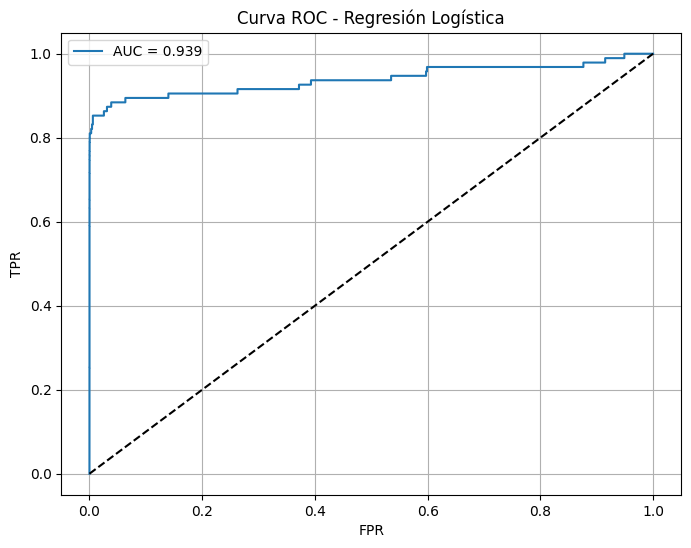

In [ ]:

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

Matriz de confusión

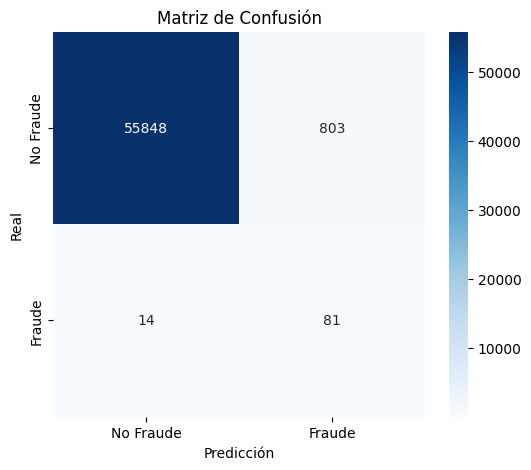

In [87]:

# Matriz de confusión bonita
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [88]:
from IPython.display import display

# Genera el reporte como diccionario
report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Redondea y muestra como tabla bonita
print("Reporte de clasificación:")
display(report_df.style.format("{:.3f}").background_gradient(cmap='Blues'))


Reporte de clasificación:


,precision,recall,f1-score,support
0,1.000,0.986,0.993,56651.000
1,0.092,0.853,0.165,95.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.546,0.919,0.579,56746.000
weighted avg,0.998,0.986,0.991,56746.000


Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [89]:
# Guarda el modelo entrenado en un DataFrame
modelos=[]
f1_score_fraudes=[]
modelos.append('regresion_logistica+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

,Modelo,f1_score_fraudes
0,regresion_logistica+PCA,0.17


### <span style = 'color: green'>**3.1.2**</span> Modelación basado ajuste PCA-Equilibrio-Randomforest:

Dado que ya se encuentra normalizado el dataset y equilibrado para datos desbalanceados se pasara a correr modelos

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline

pipe_rf = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', RandomForestClassifier(random_state=202508))
])

param_dist_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10]
}

random_search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                                             ('clf',
                                              RandomForestClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__max_depth': [None, 10],
                                        'clf__n_estimators': [100, 200]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [91]:
# Mejor modelo
best_model = random_search_rf.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                ('clf', RandomForestClassifier(random_state=202508))])

Curva roc para el ajuste del modelo de entrenamiento:

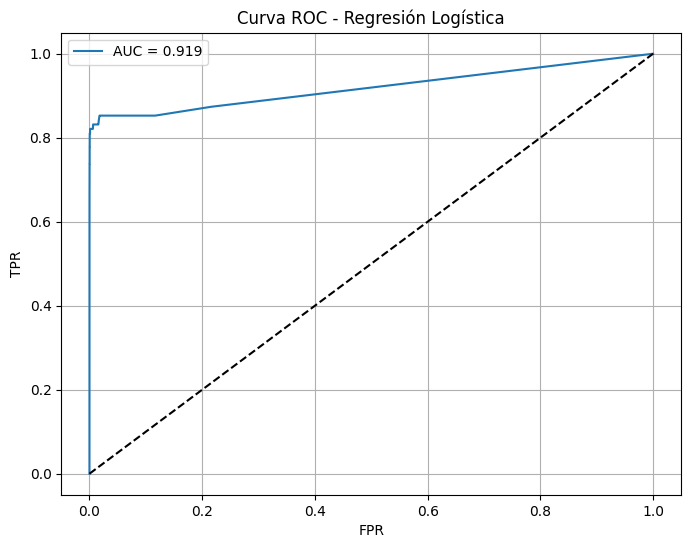

In [ ]:

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

Matriz de confusión

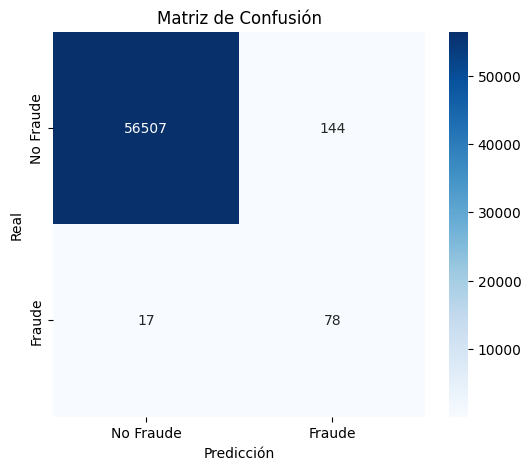

In [93]:

# Matriz de confusión bonita
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [94]:
from IPython.display import display

# Genera el reporte como diccionario
report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Redondea y muestra como tabla bonita
print("Reporte de clasificación:")
display(report_df.style.format("{:.3f}").background_gradient(cmap='Blues'))


Reporte de clasificación:


,precision,recall,f1-score,support
0,1.000,0.997,0.999,56651.000
1,0.351,0.821,0.492,95.000
accuracy,0.997,0.997,0.997,0.997
macro avg,0.676,0.909,0.745,56746.000
weighted avg,0.999,0.997,0.998,56746.000


Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [95]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('regresion_random_forest+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

,Modelo,f1_score_fraudes
0,regresion_logistica+PCA,0.17
1,regresion_random_forest+PCA,0.49


### <span style = 'color: green'>**3.1.3**</span> Modelación basado ajuste PCA-Equilibrio-Decision tree:

Dado que ya se encuentra normalizado el dataset y equilibrado para datos desbalanceados se pasara a correr modelos

In [ ]:

pipe_tree = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', DecisionTreeClassifier(random_state=202508))
])

param_dist_tree = {
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [2, 5]
}

random_search_tree = RandomizedSearchCV(
    pipe_tree,
    param_distributions=param_dist_tree,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_tree.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                                             ('clf',
                                              DecisionTreeClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__max_depth': [5, 10],
                                        'clf__min_samples_split': [2, 5]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [97]:
# Mejor modelo
best_model = random_search_tree.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                ('clf',
                 DecisionTreeClassifier(max_depth=10, min_samples_split=5,
                                        random_state=202508))])

Curva roc para el ajuste del modelo de entrenamiento:

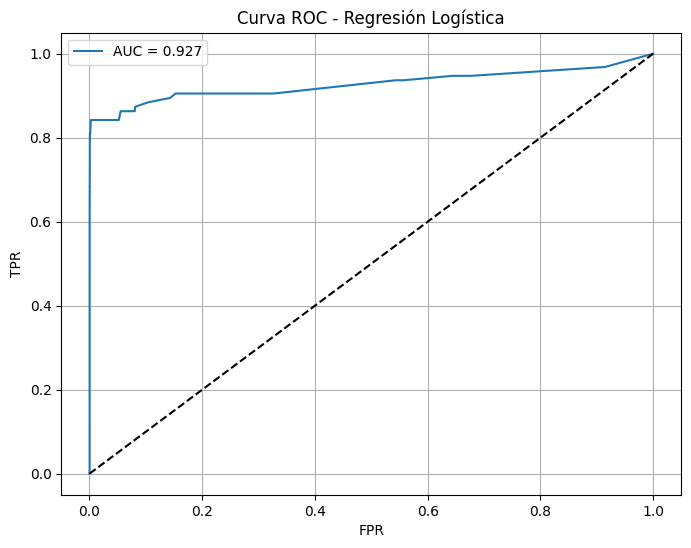

In [ ]:

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

Matriz de confusión

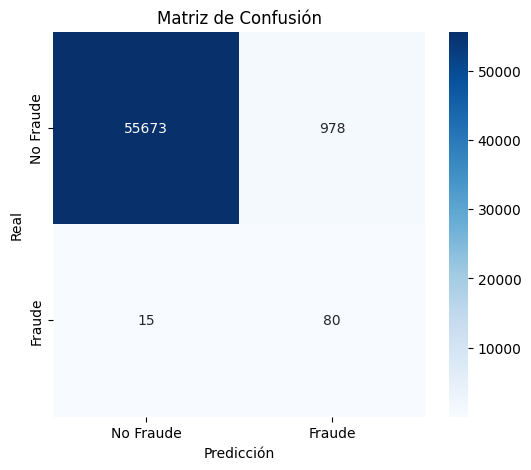

In [99]:

# Matriz de confusión bonita
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [100]:
from IPython.display import display

# Genera el reporte como diccionario
report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Redondea y muestra como tabla bonita
print("Reporte de clasificación:")
display(report_df.style.format("{:.3f}").background_gradient(cmap='Blues'))


Reporte de clasificación:


,precision,recall,f1-score,support
0,1.000,0.983,0.991,56651.000
1,0.076,0.842,0.139,95.000
accuracy,0.983,0.983,0.983,0.983
macro avg,0.538,0.912,0.565,56746.000
weighted avg,0.998,0.983,0.990,56746.000


Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [101]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('Decisicion_tree+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

,Modelo,f1_score_fraudes
0,regresion_logistica+PCA,0.17
1,regresion_random_forest+PCA,0.49
2,Decisicion_tree+PCA,0.14


### <span style = 'color: green'>**3.1.4**</span> Modelación basado ajuste PCA-Equilibrio-Hist gradient boosting:

Dado que ya se encuentra normalizado el dataset y equilibrado para datos desbalanceados se pasara a correr modelos

In [103]:


pipe_hgb = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', HistGradientBoostingClassifier(random_state=202508))
])

param_dist_hgb = {
    'clf__max_iter': [100, 200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': [None, 10],
    'clf__l2_regularization': [0.0, 1.0]
}

random_search_hgb = RandomizedSearchCV(
    pipe_hgb,
    param_distributions=param_dist_hgb,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_hgb.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                                             ('clf',
                                              HistGradientBoostingClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__l2_regularization': [0.0, 1.0],
                                        'clf__learning_rate': [0.01, 0.1],
                                        'clf__max_depth': [None, 10],
                                        'clf__max_iter': [100, 200]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [104]:
# Mejor modelo
best_model = random_search_hgb.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                ('clf',
                 HistGradientBoostingClassifier(max_iter=200,
                                                random_state=202508))])

Curva roc para el ajuste del modelo de entrenamiento:

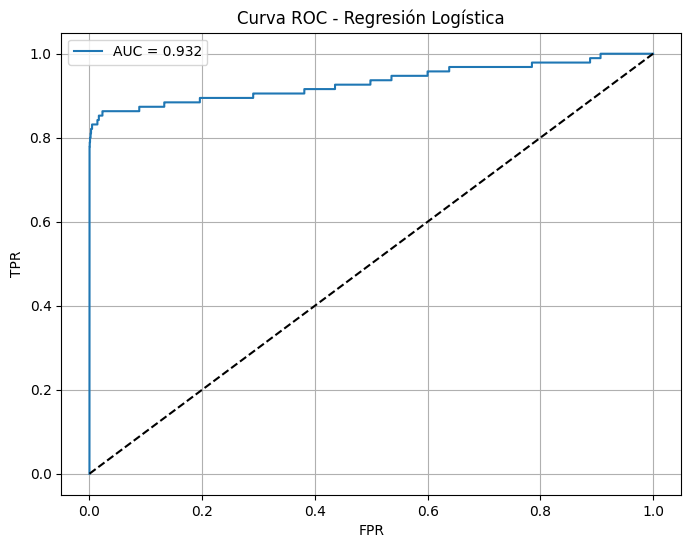

In [ ]:

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

Matriz de confusión

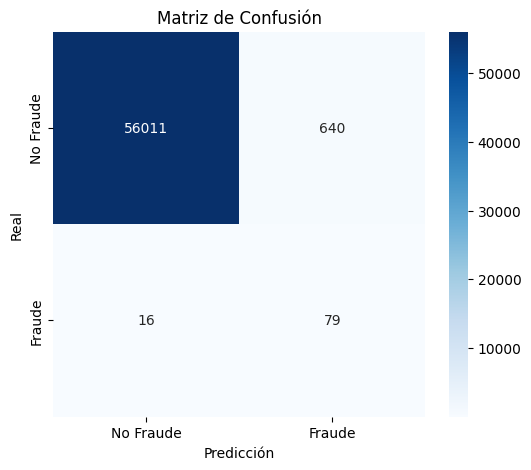

In [106]:

# Matriz de confusión bonita
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [107]:
from IPython.display import display

# Genera el reporte como diccionario
report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Redondea y muestra como tabla bonita
print("Reporte de clasificación:")
display(report_df.style.format("{:.3f}").background_gradient(cmap='Blues'))


Reporte de clasificación:


,precision,recall,f1-score,support
0,1.000,0.989,0.994,56651.000
1,0.110,0.832,0.194,95.000
accuracy,0.988,0.988,0.988,0.988
macro avg,0.555,0.910,0.594,56746.000
weighted avg,0.998,0.988,0.993,56746.000


Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [108]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('hist_gradient_boosting+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

,Modelo,f1_score_fraudes
0,regresion_logistica+PCA,0.17
1,regresion_random_forest+PCA,0.49
2,Decisicion_tree+PCA,0.14
3,hist_gradient_boosting+PCA,0.19


### <span style = 'color: green'>**3.1.5**</span> Modelación basado ajuste PCA-Equilibrio-MLP-classifier:

Dado que ya se encuentra normalizado el dataset y equilibrado para datos desbalanceados se pasara a correr modelos

In [111]:
from sklearn.neural_network import MLPClassifier

pipe_mlp = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', MLPClassifier(max_iter=200, random_state=202508))
])

param_dist_mlp = {
    'clf__hidden_layer_sizes': [(50,), (100,)],
    'clf__activation': ['relu'],
    'clf__alpha': [0.0001, 0.001]
}

random_search_mlp = RandomizedSearchCV(
    pipe_mlp,
    param_distributions=param_dist_mlp,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_mlp.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                                             ('clf',
                                              MLPClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__activation': ['relu'],
                                        'clf__alpha': [0.0001, 0.001],
                                        'clf__hidden_layer_sizes': [(50,),
                                                                    (100,)]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [112]:
# Mejor modelo
best_model = random_search_mlp.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                ('clf', MLPClassifier(alpha=0.001, random_state=202508))])

Curva roc para el ajuste del modelo de entrenamiento:

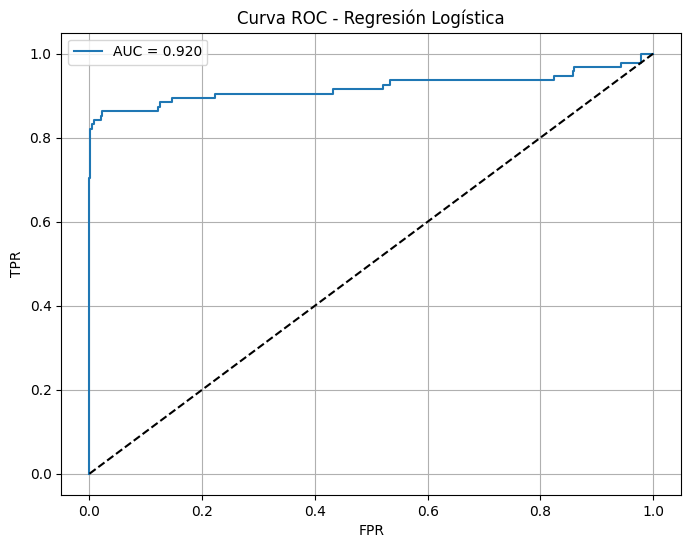

In [ ]:

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

Matriz de confusión

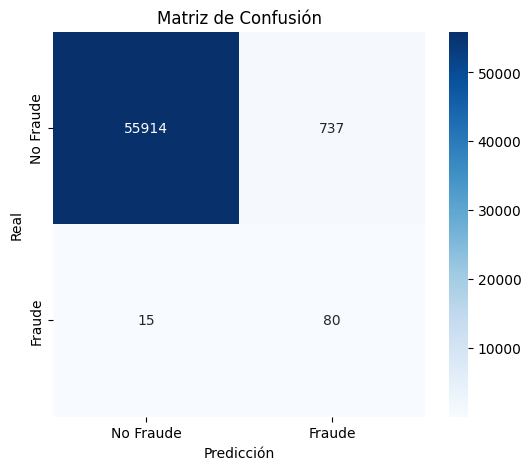

In [114]:

# Matriz de confusión bonita
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [115]:
from IPython.display import display

# Genera el reporte como diccionario
report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Redondea y muestra como tabla bonita
print("Reporte de clasificación:")
display(report_df.style.format("{:.3f}").background_gradient(cmap='Blues'))


Reporte de clasificación:


,precision,recall,f1-score,support
0,1.000,0.987,0.993,56651.000
1,0.098,0.842,0.175,95.000
accuracy,0.987,0.987,0.987,0.987
macro avg,0.549,0.915,0.584,56746.000
weighted avg,0.998,0.987,0.992,56746.000


Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [116]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('MLP_classifier+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

,Modelo,f1_score_fraudes
0,regresion_logistica+PCA,0.17
1,regresion_random_forest+PCA,0.49
2,Decisicion_tree+PCA,0.14
3,hist_gradient_boosting+PCA,0.19
4,MLP_classifier+PCA,0.18


### <span style = 'color: green'>**3.1.6**</span> Modelación basado ajuste PCA-Equilibrio-Light Gradient Boosting Machine:

Dado que ya se encuentra normalizado el dataset y equilibrado para datos desbalanceados se pasara a correr modelos

In [ ]:


pipe_lgbm = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', LGBMClassifier(random_state=202508))
])

param_dist_lgbm = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, -1],
    'clf__learning_rate': [0.01, 0.1]
}

random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_lgbm.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] Number of positive: 226602, number of negative: 226602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 453204, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                                             ('clf',
                                              LGBMClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__learning_rate': [0.01, 0.1],
                                        'clf__max_depth': [5, 10, -1],
                                        'clf__n_estimators': [100, 200]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [118]:
# Mejor modelo
best_model = random_search_lgbm.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                ('clf', LGBMClassifier(max_depth=5, random_state=202508))])

Curva roc para el ajuste del modelo de entrenamiento:

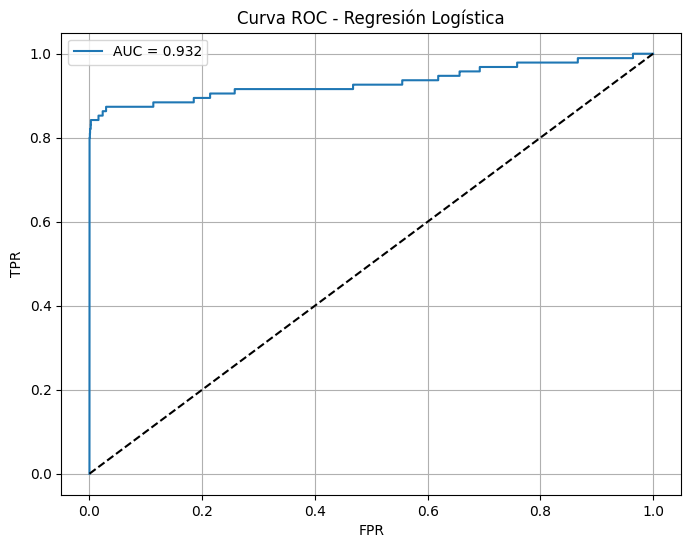

In [ ]:

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

Matriz de confusión

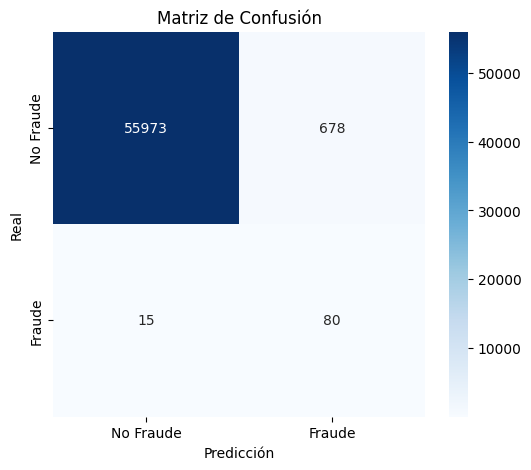

In [120]:

# Matriz de confusión bonita
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [121]:
from IPython.display import display

# Genera el reporte como diccionario
report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Redondea y muestra como tabla bonita
print("Reporte de clasificación:")
display(report_df.style.format("{:.3f}").background_gradient(cmap='Blues'))


Reporte de clasificación:


,precision,recall,f1-score,support
0,1.000,0.988,0.994,56651.000
1,0.106,0.842,0.188,95.000
accuracy,0.988,0.988,0.988,0.988
macro avg,0.553,0.915,0.591,56746.000
weighted avg,0.998,0.988,0.992,56746.000


Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [122]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('lgbm_classifier+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

,Modelo,f1_score_fraudes
0,regresion_logistica+PCA,0.17
1,regresion_random_forest+PCA,0.49
2,Decisicion_tree+PCA,0.14
3,hist_gradient_boosting+PCA,0.19
4,MLP_classifier+PCA,0.18
5,lgbm_classifier+PCA,0.19


### <span style = 'color: green'>**3.1.7**</span> Modelación basado ajuste PCA-Equilibrio-XGBOOST:

Dado que ya se encuentra normalizado el dataset y equilibrado para datos desbalanceados se pasara a correr modelos

In [126]:


pipe_xgb = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', XGBClassifier(random_state=202508, use_label_encoder=False, eval_metric='logloss'))
])

param_dist_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10],
    'clf__learning_rate': [0.01, 0.1]
}

random_search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


c:\Users\user\Documents\aprendmaq_proy_final\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='lo...
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=202508, ...))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__learning_rate': [0.01, 0.1],
                                        'clf__max_depth': [5, 10],
                                        'clf__n_estimators': [100, 200]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [127]:
# Mejor modelo
best_model = random_search_xgb.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x0000023F81DD8790>)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=No...row_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=202508, ...))])

Curva roc para el ajuste del modelo de entrenamiento:

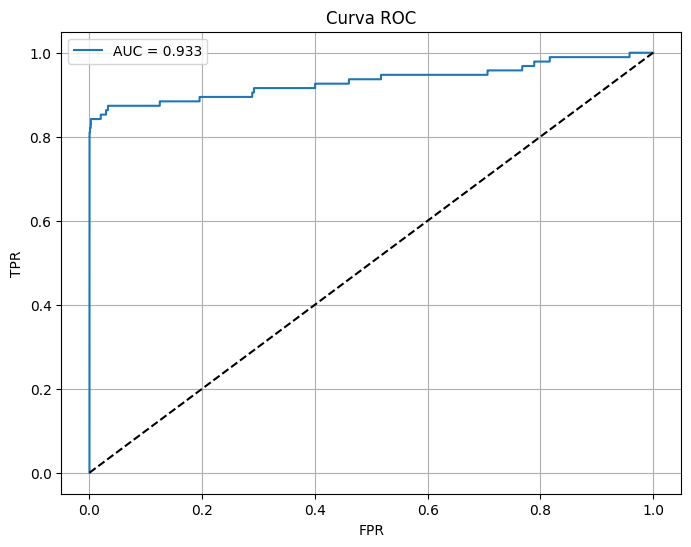

In [131]:

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

Matriz de confusión

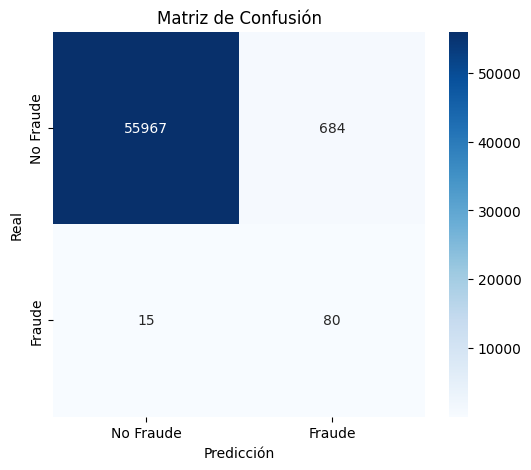

In [132]:

# Matriz de confusión bonita
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [133]:
from IPython.display import display

# Genera el reporte como diccionario
report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Redondea y muestra como tabla bonita
print("Reporte de clasificación:")
display(report_df.style.format("{:.3f}").background_gradient(cmap='Blues'))


Reporte de clasificación:


,precision,recall,f1-score,support
0,1.000,0.988,0.994,56651.000
1,0.105,0.842,0.186,95.000
accuracy,0.988,0.988,0.988,0.988
macro avg,0.552,0.915,0.590,56746.000
weighted avg,0.998,0.988,0.992,56746.000


Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [135]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('XGBM+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
}).sort_values('f1_score_fraudes', ascending=False).reset_index(drop=True)

,Modelo,f1_score_fraudes
0,regresion_random_forest+PCA,0.49
1,hist_gradient_boosting+PCA,0.19
2,lgbm_classifier+PCA,0.19
3,XGBM+PCA,0.19
4,XGBM+PCA,0.19
5,MLP_classifier+PCA,0.18
6,regresion_logistica+PCA,0.17
7,Decisicion_tree+PCA,0.14


### Conclusión:

Finalmente basado en los datos obtenidos concluimos que el mejor modelo basado en la información persistente y bajo las transformaciones obtenidas es randomforest con PCA